In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [2]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

Mounted at /content/drive


In [4]:
# path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

In [5]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [6]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

# Apply the mapping to create numerical labels
y = df['Interaction'].replace(contact_dict)
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

<ipython-input-6-1592439739>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


In [7]:
# Encode categorical features
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

In [8]:
# Count total missing values per column
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


In [9]:
# Fill None values with the mean of the values of that column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

Total missing values, after refilling: 0

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
0 -2.322  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0   
1 -1.788  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0   
2 -2.390  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0   
3 -1.088 -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0   
4 -1.551 -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0   

   s_ss8_encoded  t_ss8_encoded  
0              3              7  


## Feature engineering


*   Sum
*   Product
*   Absolute difference
*   Average



In [10]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names


In [11]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
# UPDATE WITH NEW ENGINEERED FEATURES
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

for feature in features:
  feature_names.extend(fe(feature))

Engineering feature: ss8_encoded
   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   ...   t_a3   t_a4   t_a5  t_3di_state  s_ss8_encoded  t_ss8_encoded  \
0  ...  0.533 -0.277  1.648          6.0              3              7   
1  ... -0.862 -1.020 -0.255          4.0              0              1   
2  ... -3.005 -0.503 -1.853          2.0              2              0   
3  ... -4.760  0.670 -2.647         17.0              4              4   
4  ...  1.477  0.113 -0.837         13.0              0              3   

   ss8_encoded_sum  ss8_encoded_abs

In [12]:
print(feature_names)

['s_ss8', 's_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 'ss8_encoded_sum', 'ss8_encoded_abs_diff', 'ss8_encoded_prod', 'ss8_encoded_avg', 'rsa_sum', 'rsa_abs_diff', 'rsa_prod', 'rsa_avg', 'phi_sum', 'phi_abs_diff', 'phi_prod', 'phi_avg', 'psi_sum', 'psi_abs_diff', 'psi_prod', 'psi_avg', 'a1_sum', 'a1_abs_diff', 'a1_prod', 'a1_avg', 'a2_sum', 'a2_abs_diff', 'a2_prod', 'a2_avg', 'a3_sum', 'a3_abs_diff', 'a3_prod', 'a3_avg', 'a4_sum', 'a4_abs_diff', 'a4_prod', 'a4_avg', 'a5_sum', 'a5_abs_diff', 'a5_prod', 'a5_avg', '3di_state_sum', '3di_state_abs_diff', '3di_state_prod', '3di_state_avg']


## Scaling features

In [13]:
# Scale all features to the range [0, 1]
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)
input_dim = X_scaled.shape[1]

In [14]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.2,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [15]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

0: 675794
1: 471719
2: 24501
3: 22650
4: 5686
5: 1344
6: 1146
7: 697310


In [16]:
sampling_strategy = {
    0: 675794,  # HBOND
    1: 471719,  # VDW
    2: 24501,  # PIPISTACK
    3: 22650,  # IONIC
    4: 20000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 697310   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_train_bal, y_train_bal = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train_bal)):
    print(f"{label}: {Counter(y_train_bal)[label]}")


Resampled y_train_bal distribution
0: 675794
1: 471719
2: 24501
3: 22650
4: 20000
5: 10000
6: 10000
7: 697310


## 2 - LOAD Existing data


In [ ]:
# X_bal = np.load(path + '/X_bal-SMOTE22.npy')
# y_bal = np.load(path + '/y_bal-SMOTE22.npy')

In [ ]:
# print('Original y_train distribution:', Counter(y_train))
# print('Resampled y_bal distribution:', Counter(y_bal))

In [ ]:
# # Count the class in X_bal
# unique_values, counts = np.unique(y_bal, return_counts=True)
# print(dict(zip(unique_values, counts)))

In [17]:
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

## XGBoost

### Helper functions

In [18]:
def feature_importance(model, interaction_type, feature_names):
  # Estrai le importanze delle feature
  importance = model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'

  # Ordinare le feature per importanza
  # Create a mapping from old keys to new feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

  # Replace keys in the importance dictionary
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sort the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Visualizza l'importanza delle feature
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
  plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
  plt.show()

In [19]:
import time

def evaluate_model(model, X_test, y_test, class_num, feature_names):
    """
    Evaluate performance of an XGBoost model.

    Parameters:
    -----------
    model_path: str
        Path to the model file
    X_test: numpy array
        Test features
    y_test: numpy array
        Test labels
    class_num: int
        Class number for binary evaluation
    """
    # Binary labels for test data
    y_test_binary = (y_test == class_num).astype(int)

    # Convert test data to DMatrix
    dtest = xgb.DMatrix(X_test)

    # Get predictions from the model
    start_time = time.time()
    y_pred_prob = model.predict(dtest)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'AUC-ROC',
            'Matthews Correlation',
            'Average Precision',
            'Inference Time (ms)',
        ],
        'Value': [
            accuracy_score(y_test_binary, y_pred_binary),
            balanced_accuracy_score(y_test_binary, y_pred_binary),
            roc_auc_score(y_test_binary, y_pred_prob),
            matthews_corrcoef(y_test_binary, y_pred_binary),
            average_precision_score(y_test_binary, y_pred_prob),
            inference_time * 1000,
        ]
    }

    # Create a DataFrame for metrics
    metrics_df = pd.DataFrame(metrics)

    print(f"\n===== Performance Metrics for Class {class_num} =====")
    print(metrics_df.set_index('Metric').round(4))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Other', f'Class {class_num}'],
                yticklabels=['Other', f'Class {class_num}'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Class {class_num}')
    plt.show()

    print(f"\n===== Feature Importance for Class {class_num} =====")

    # 8. Feature importance
    feature_importance(model, class_num, feature_names)

    return metrics_df, y_pred_prob

### Train loop

Training classifier for Class 0
[0]	validation-auc:0.63560
[100]	validation-auc:0.71388
[179]	validation-auc:0.71507

===== Performance Metrics for Class 0 =====
                         Value
Metric                        
Accuracy                0.6418
Balanced Accuracy       0.6575
AUC-ROC                 0.7169
Matthews Correlation    0.3016
Average Precision       0.5519
Inference Time (ms)   137.0692


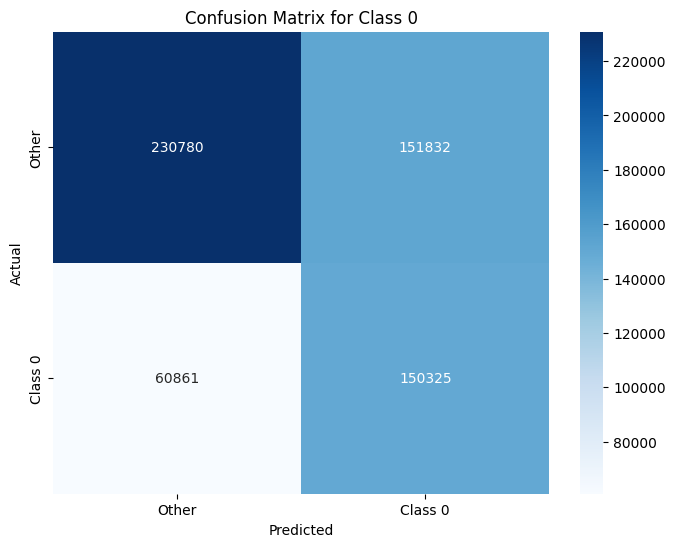


===== Feature Importance for Class 0 =====


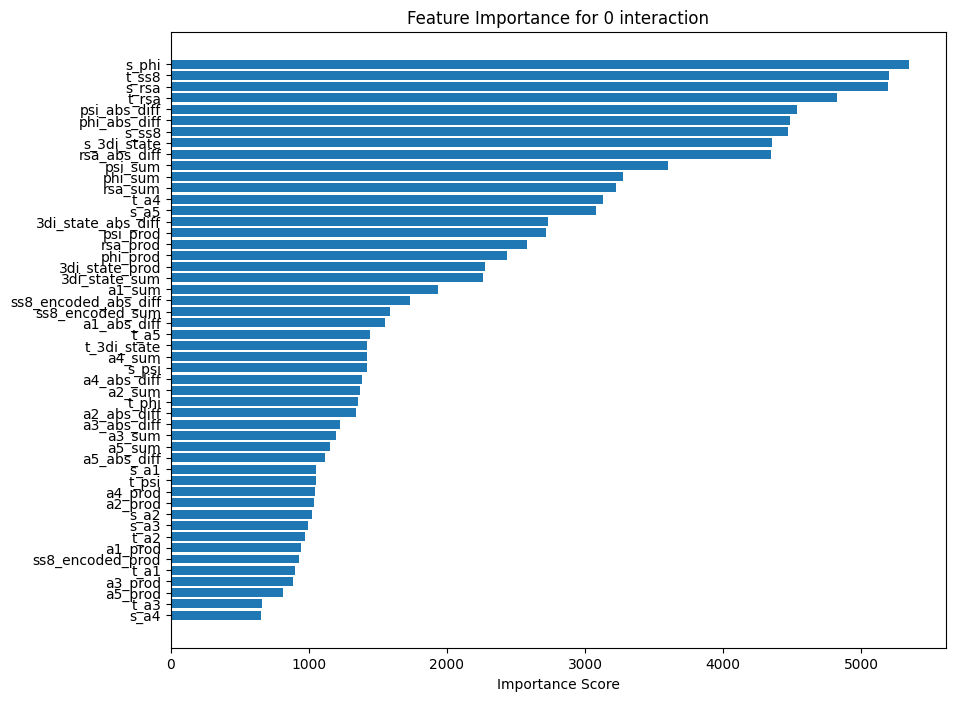

Training classifier for Class 1
[0]	validation-auc:0.53790
[43]	validation-auc:0.55156

===== Performance Metrics for Class 1 =====
                        Value
Metric                       
Accuracy               0.5183
Balanced Accuracy      0.5368
AUC-ROC                0.5527
Matthews Correlation   0.0636
Average Precision      0.2815
Inference Time (ms)   84.8553


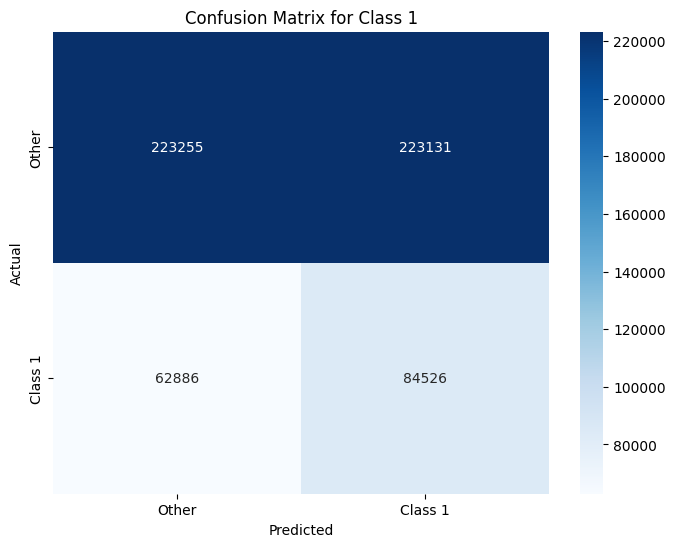


===== Feature Importance for Class 1 =====


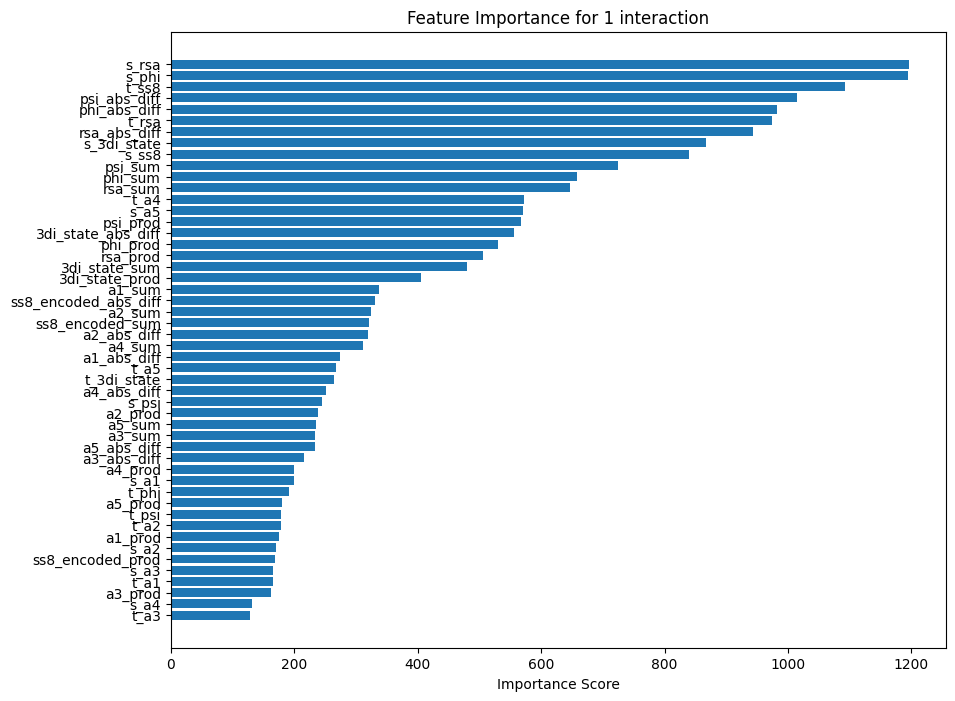

Training classifier for Class 2
[0]	validation-auc:0.98997
[59]	validation-auc:0.99075

===== Performance Metrics for Class 2 =====
                        Value
Metric                       
Accuracy               0.9792
Balanced Accuracy      0.9855
AUC-ROC                0.9906
Matthews Correlation   0.6086
Average Precision      0.4309
Inference Time (ms)   80.5690


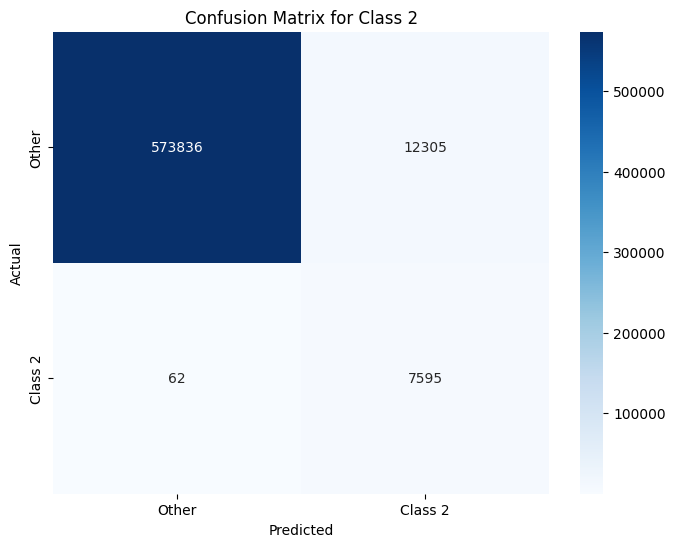


===== Feature Importance for Class 2 =====


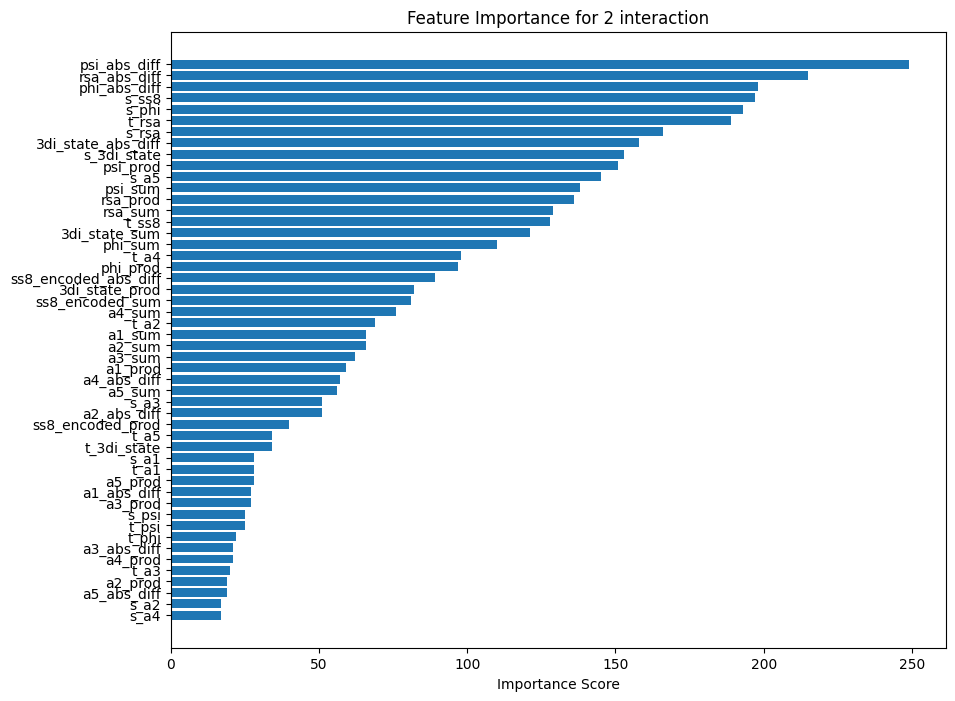

Training classifier for Class 3
[0]	validation-auc:0.97656
[52]	validation-auc:0.97771

===== Performance Metrics for Class 3 =====
                        Value
Metric                       
Accuracy               0.9428
Balanced Accuracy      0.9602
AUC-ROC                0.9771
Matthews Correlation   0.3952
Average Precision      0.2346
Inference Time (ms)   81.6443


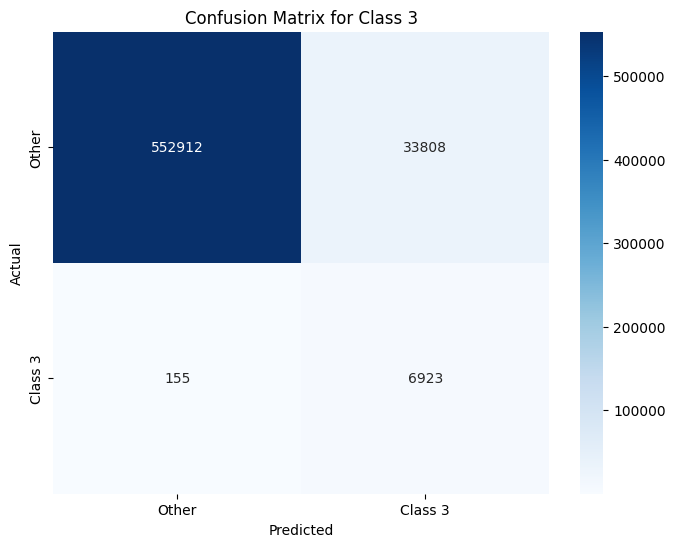


===== Feature Importance for Class 3 =====


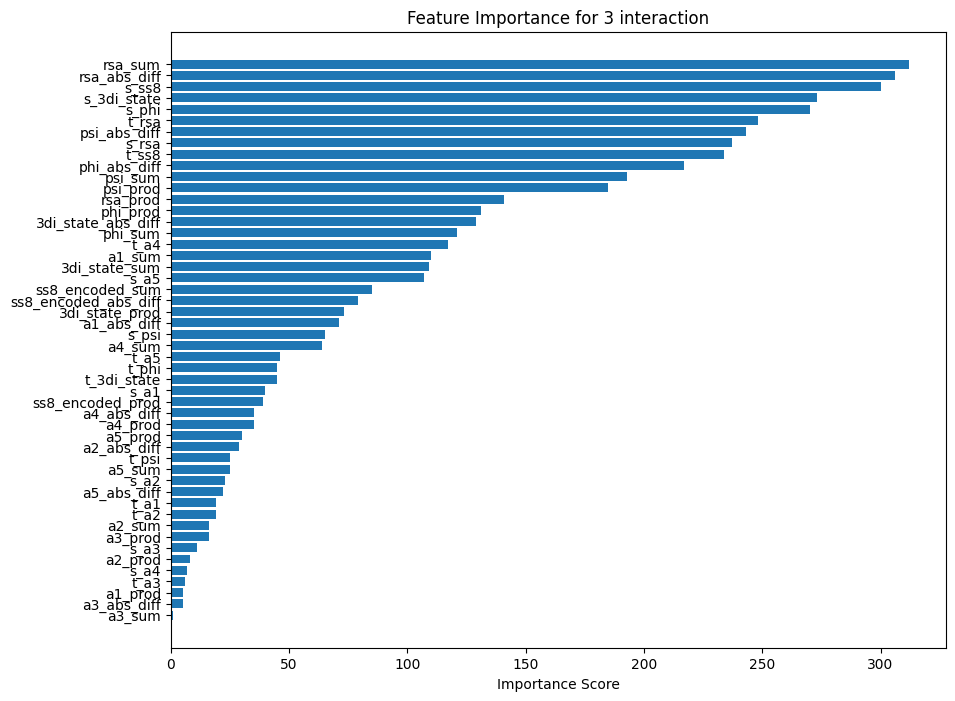

Training classifier for Class 4
[0]	validation-auc:0.98958
[40]	validation-auc:0.99061

===== Performance Metrics for Class 4 =====
                        Value
Metric                       
Accuracy               0.9784
Balanced Accuracy      0.9549
AUC-ROC                0.9912
Matthews Correlation   0.3232
Average Precision      0.1771
Inference Time (ms)   81.7750


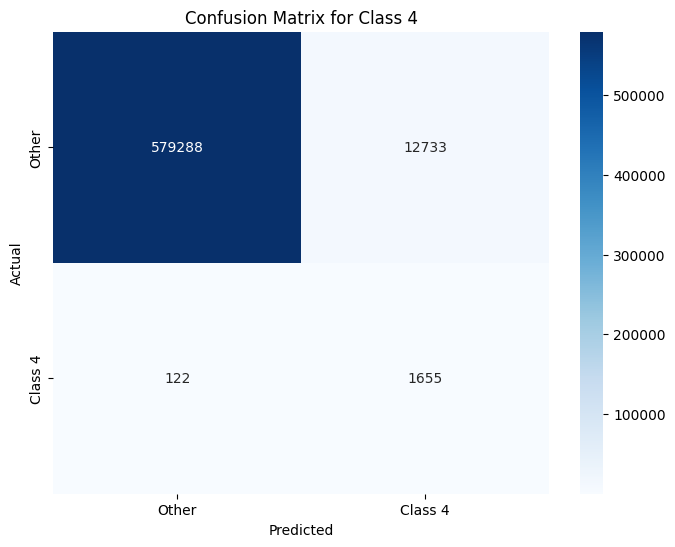


===== Feature Importance for Class 4 =====


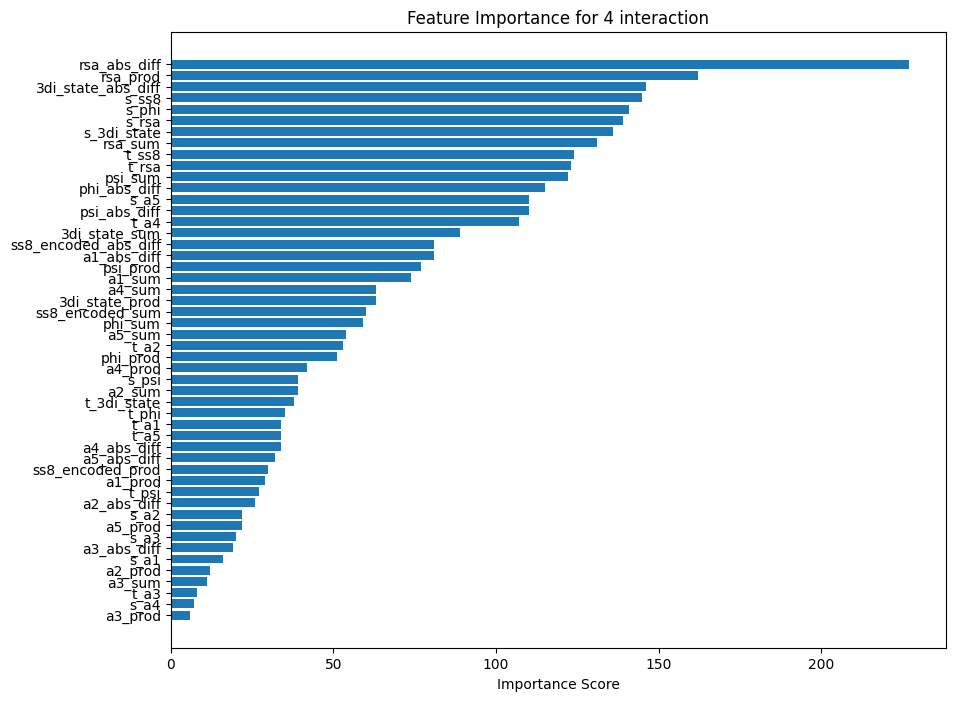

Training classifier for Class 5
[0]	validation-auc:0.99945
[33]	validation-auc:0.99951

===== Performance Metrics for Class 5 =====
                        Value
Metric                       
Accuracy               0.9991
Balanced Accuracy      0.9686
AUC-ROC                0.9995
Matthews Correlation   0.6301
Average Precision      0.4109
Inference Time (ms)   71.8598


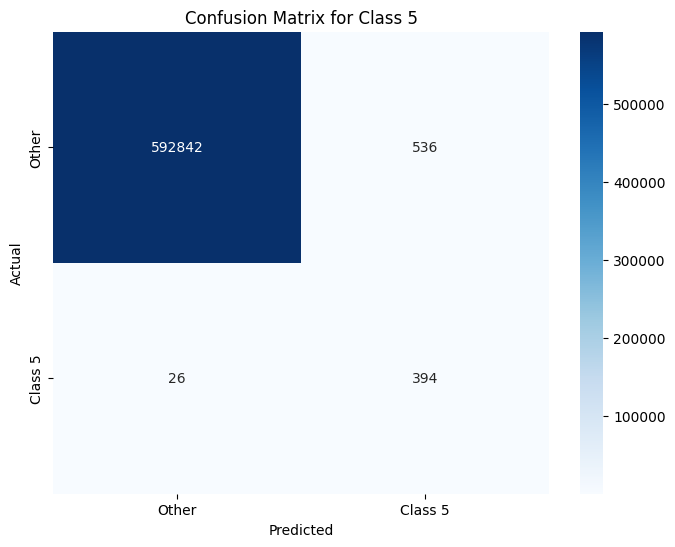


===== Feature Importance for Class 5 =====


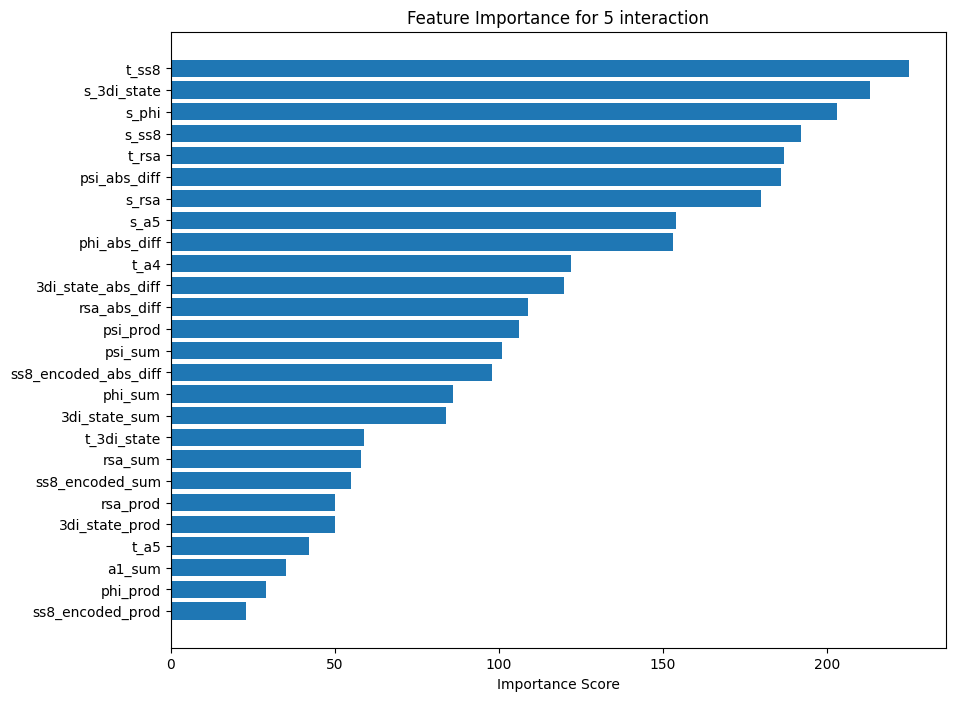

Training classifier for Class 6
[0]	validation-auc:0.93893
[83]	validation-auc:0.95618

===== Performance Metrics for Class 6 =====
                        Value
Metric                       
Accuracy               0.9969
Balanced Accuracy      0.6788
AUC-ROC                0.9613
Matthews Correlation   0.1618
Average Precision      0.0605
Inference Time (ms)   99.0074


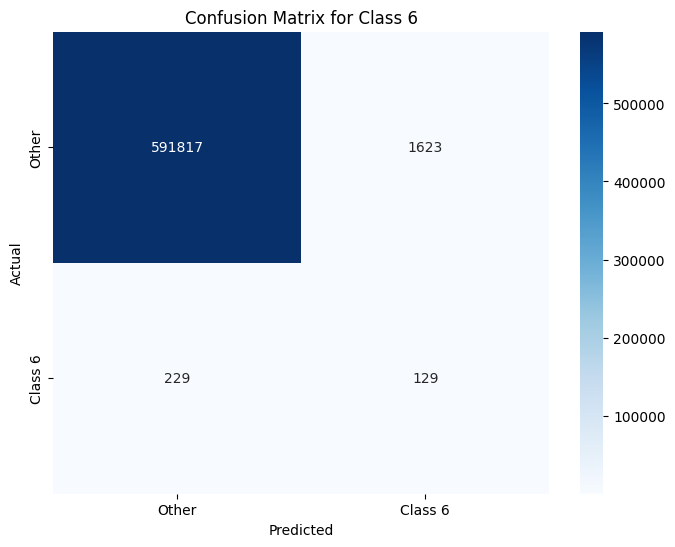


===== Feature Importance for Class 6 =====


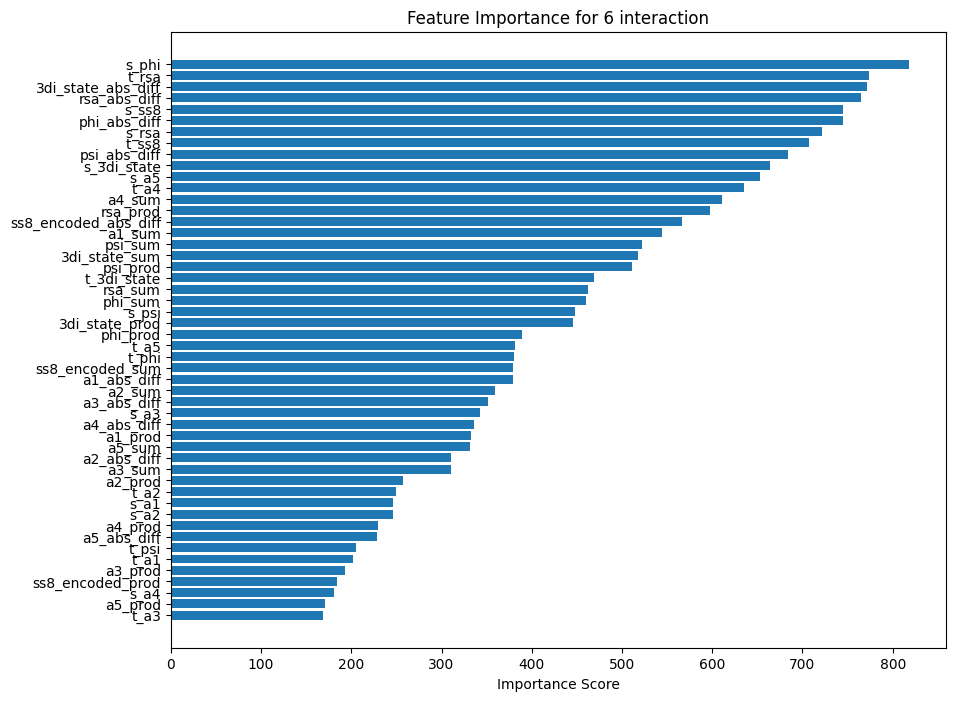

Training classifier for Class 7
[0]	validation-auc:0.65410
[100]	validation-auc:0.74398
[200]	validation-auc:0.75655
[300]	validation-auc:0.76340
[400]	validation-auc:0.76835
[500]	validation-auc:0.77188
[600]	validation-auc:0.77474
[700]	validation-auc:0.77753
[800]	validation-auc:0.77977
[900]	validation-auc:0.78194
[1000]	validation-auc:0.78366
[1100]	validation-auc:0.78519
[1200]	validation-auc:0.78672
[1300]	validation-auc:0.78816
[1400]	validation-auc:0.78919
[1500]	validation-auc:0.79046
[1600]	validation-auc:0.79158
[1700]	validation-auc:0.79248
[1800]	validation-auc:0.79335
[1900]	validation-auc:0.79457
[2000]	validation-auc:0.79551
[2100]	validation-auc:0.79638
[2200]	validation-auc:0.79723
[2300]	validation-auc:0.79799
[2400]	validation-auc:0.79886
[2499]	validation-auc:0.79959

===== Performance Metrics for Class 7 =====
                          Value
Metric                         
Accuracy                 0.7394
Balanced Accuracy        0.7167
AUC-ROC                  0.

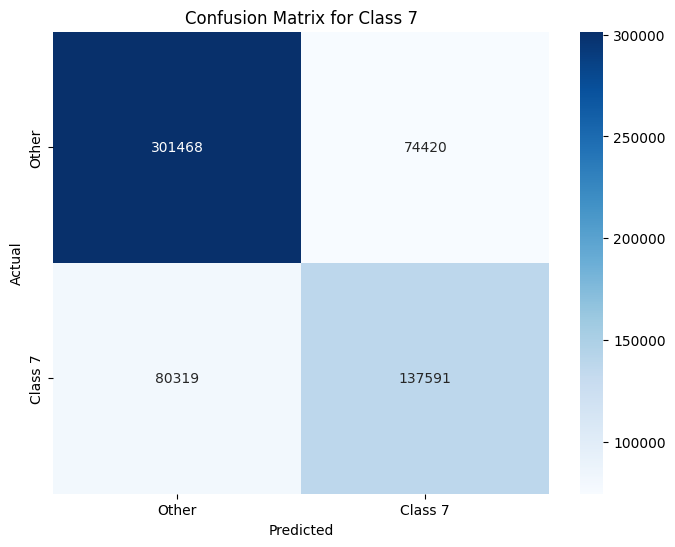


===== Feature Importance for Class 7 =====


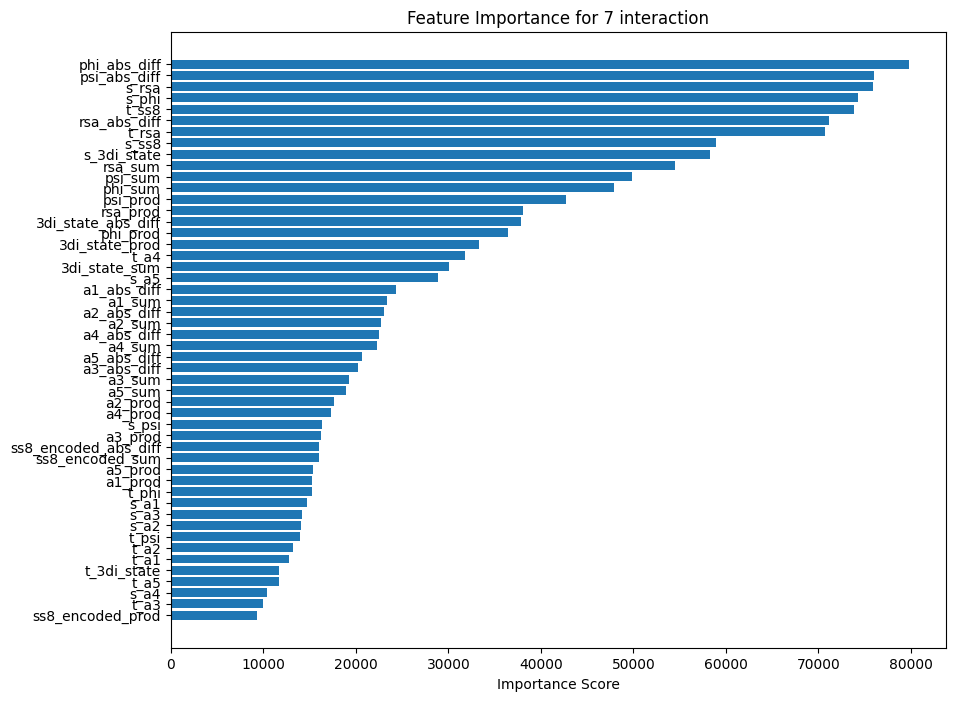

In [20]:
# Create arrays to store models and predictions
models = []
all_class_predictions = np.zeros((len(y_test), len(np.unique(y_train))))

# For each class, train a binary classifier
for num_class in range(len(np.unique(y_train))):
    print(f'Training classifier for Class {num_class}')

    # Create binary labels for ALL training examples
    # 1 for current class, 0 for all other classes
    y_train_binary = (y_train_bal == num_class).astype(int)
    y_val_binary = (y_val == num_class).astype(int)


    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train_bal, label=y_train_binary)
    dval = xgb.DMatrix(X_val, label=y_val_binary)

    # Counte num positive/negative examples for this class
    pos_class = np.sum(y_train_binary == 1)
    neg_class = np.sum(y_train_binary == 0)

    # Train model
    model = xgb.train(
        params = {
            'device': 'cuda',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 10,
            'learning_rate': 0.2,
            'scale_pos_weight': neg_class / pos_class if pos_class > 0 else 1.0,  # Handle class imbalance
            'seed': 42
        },
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dval, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=100
    )

    # Save model
    os.makedirs(os.path.join(path, 'models'), exist_ok=True)
    model.save_model(os.path.join(path, f'models/xgboost_model_class_{num_class}.json'))

    evaluate_model(model, X_test, y_test, num_class, feature_names)

    # Store the model
    models.append(model)

In [23]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict

def analyze_xgboost_model(model_path):
    """Analyze an XGBoost model JSON file and extract useful information."""
    with open(model_path, 'r') as f:
        model_data = json.load(f)

    # Extract basic model information
    results = {}

    # Model metadata and version
    results['version'] = '.'.join(map(str, model_data.get('learner', {}).get('version', ["unknown"])))

    # Model attributes (parameters)
    attributes = model_data.get('learner', {}).get('attributes', {})
    results['best_iteration'] = int(attributes.get('best_iteration', -1))
    results['best_score'] = float(attributes.get('best_score', -1))

    # Extract hyperparameters
    for key in ['max_depth', 'learning_rate', 'objective', 'eval_metric', 'num_class',
                'scale_pos_weight', 'seed', 'num_parallel_tree', 'subsample', 'colsample_bytree']:
        if key in attributes:
            try:
                value = attributes[key]
                # Convert numeric strings to proper types
                if isinstance(value, str) and value.replace('.', '', 1).isdigit():
                    if '.' in value:
                        results[key] = float(value)
                    else:
                        results[key] = int(value)
                else:
                    results[key] = value
            except:
                results[key] = attributes[key]

    # Extract tree information
    tree_model = model_data.get('learner', {}).get('gradient_booster', {}).get('model', {})

    # Tree model parameters
    gbtree_params = tree_model.get('gbtree_model_param', {})
    results['num_trees'] = int(gbtree_params.get('num_trees', 0))

    # Trees analysis
    trees = tree_model.get('trees', [])

    # Tree statistics
    tree_stats = []
    total_nodes = 0
    total_leaves = 0
    used_features = set()
    feature_importance = defaultdict(int)

    for i, tree in enumerate(trees):
        tree_param = tree.get('tree_param', {})
        num_nodes = int(tree_param.get('num_nodes', 0))
        split_indices = tree.get('split_indices', [])

        # Calculate leaves (nodes that are not internal nodes)
        internal_nodes = set()
        for j in range(len(tree.get('left_children', []))):
            if tree['left_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)
            if tree['right_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)

        num_leaves = num_nodes - len(internal_nodes)

        # Track feature usage as a simple feature importance
        for feature_idx in split_indices:
            used_features.add(feature_idx)
            feature_importance[feature_idx] += 1

        # Store tree statistics
        tree_stats.append({
            'tree_index': i,
            'num_nodes': num_nodes,
            'num_leaves': num_leaves,
            'max_depth': max_tree_depth(tree),
            'num_features_used': len(set(split_indices))
        })

        total_nodes += num_nodes
        total_leaves += num_leaves

    results['total_nodes'] = total_nodes
    results['total_leaves'] = total_leaves
    results['avg_nodes_per_tree'] = total_nodes / results['num_trees'] if results['num_trees'] > 0 else 0
    results['avg_leaves_per_tree'] = total_leaves / results['num_trees'] if results['num_trees'] > 0 else 0
    results['num_features_used'] = len(used_features)

    # Sort feature importance
    results['top_features'] = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]

    # Compute tree depth statistics
    depths = [stat['max_depth'] for stat in tree_stats]
    results['min_tree_depth'] = min(depths) if depths else 0
    results['max_tree_depth'] = max(depths) if depths else 0
    results['avg_tree_depth'] = sum(depths) / len(depths) if depths else 0

    # File metrics
    results['file_size_kb'] = os.path.getsize(model_path) / 1024

    return results, tree_stats

def max_tree_depth(tree):
    """Calculate the maximum depth of a tree by following child nodes."""
    left = tree.get('left_children', [])
    right = tree.get('right_children', [])

    if not left or not right:
        return 0

    # Use BFS to find the maximum depth
    depths = {0: 0}  # node_id: depth
    max_depth = 0

    for node_id in range(len(left)):
        node_depth = depths.get(node_id, 0)

        # Process left child
        if left[node_id] >= 0:  # Valid node
            depths[left[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)

        # Process right child
        if right[node_id] >= 0:  # Valid node
            depths[right[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)

    return max_depth

# Usage example
#models_dir = '/Users/sebastianosanson/Development/Contacts-Classification/models'
models_dir = '/content/drive/MyDrive/models'
all_model_results = []
all_tree_stats = []

# Process all model files
for filename in sorted(os.listdir(models_dir)):
    if filename.endswith('.json'):
        model_path = os.path.join(models_dir, filename)
        class_num = int(filename.split('_')[-1].split('.')[0])

        # Extract model information
        model_info, tree_stats = analyze_xgboost_model(model_path)
        model_info['class'] = class_num

        # Add model information to results
        all_model_results.append(model_info)

        # Add tree statistics with model identifier
        for stat in tree_stats:
            stat['class'] = class_num
            all_tree_stats.append(stat)

# Create DataFrame for easy analysis
models_df = pd.DataFrame(all_model_results)
trees_df = pd.DataFrame(all_tree_stats)

# Print the high-level model information
print("\n===== MODEL INFORMATION =====")
print(models_df[['class', 'num_trees', 'best_iteration', 'best_score',
                 'total_nodes', 'avg_nodes_per_tree', 'avg_tree_depth',
                 'file_size_kb']].sort_values('class'))

# Print tree depth statistics
print("\n===== TREE DEPTH STATISTICS =====")
tree_depth_stats = trees_df.groupby('class').agg({
    'max_depth': ['min', 'max', 'mean']
}).reset_index()
print(tree_depth_stats)

# Feature importance across models
print("\n===== TOP FEATURES BY CLASS =====")
for i, model in enumerate(all_model_results):
    print(f"\nClass {model['class']} top features:")
    for feature_idx, count in model['top_features'][:]:
        print(f"  Feature {feature_names[feature_idx]}: used {count} times")


===== MODEL INFORMATION =====
   class  num_trees  best_iteration  best_score  total_nodes  \
0      0        181             160    0.715234       219557   
1      1         45              24    0.552467        44293   
2      2         61              40    0.991217         8637   
3      3         54              33    0.978190         9998   
4      4         41              20    0.991043         6891   
5      5         35              14    0.999544         5875   
6      6         84              63    0.957095        44454   
7      7       2500            2499    0.799587      3140252   

   avg_nodes_per_tree  avg_tree_depth   file_size_kb  
0         1213.022099            10.0   13476.451172  
1          984.288889            10.0    2714.536133  
2          141.590164            10.0     537.716797  
3          185.148148            10.0     613.997070  
4          168.073171            10.0     425.244141  
5          167.857143             9.2     363.102539  
6      

## Train with top 50% features

In [35]:
top_features_per_class = {}

for model in all_model_results:
    class_label = model['class']
    total_features = len(model['top_features'])
    features_to_keep = (total_features + 1) // 2  # Top 50%, rounded up
    top_features_per_class[class_label] = [
        feature_idx for feature_idx, _ in model['top_features'][:features_to_keep]
    ]

In [29]:
# Initialize storage for models and predictions
models_top = []
all_class_predictions_top = np.zeros((len(y_test), len(np.unique(y_train))))

# For each class, train a binary classifier on its top features
for num_class in range(len(np.unique(y_train))):
    print(f'\nTraining classifier for Class {num_class} (Top 50% Features)')

    # Get the top feature indices for this class
    selected_features = top_features_per_class[num_class]

    # Filter training/validation/test data (NumPy array indexing)
    X_train_class = X_train_bal[:, selected_features]
    X_val_class = X_val[:, selected_features]
    X_test_class = X_test[:, selected_features]

    # Create binary labels (1 = current class, 0 = others)
    y_train_binary = (y_train_bal == num_class).astype(int)
    y_val_binary = (y_val == num_class).astype(int)

    # Create DMatrix objects (XGBoost optimized format)
    dtrain = xgb.DMatrix(X_train_class, label=y_train_binary)
    dval = xgb.DMatrix(X_val_class, label=y_val_binary)
    dtest = xgb.DMatrix(X_test_class)

    # Handle class imbalance
    pos_class = np.sum(y_train_binary == 1)
    neg_class = np.sum(y_train_binary == 0)
    scale_pos_weight = neg_class / pos_class if pos_class > 0 else 1.0

    # Train model
    model = xgb.train(
        params={
            'device': 'cuda',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 10,
            'learning_rate': 0.2,
            'scale_pos_weight': scale_pos_weight,
            'seed': 42
        },
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dval, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=100
    )

    # Save model
    os.makedirs(os.path.join(path, 'models_top50'), exist_ok=True)
    model.save_model(os.path.join(path, f'models_top50/xgboost_model_class_{num_class}.json'))

    # Store the model
    models_top.append(model)

    # Evaluate
    y_pred_proba = model.predict(dtest)
    all_class_predictions_top[:, num_class] = y_pred_proba

    # Print metrics
    print(f'\nEvaluation for Class {num_class}:')
    print(f"  Test AUC: {roc_auc_score((y_test == num_class).astype(int), y_pred_proba):.4f}")
    print(f"  Test AP: {average_precision_score((y_test == num_class).astype(int), y_pred_proba):.4f}")

# Combine predictions (e.g., for multiclass voting)
final_predictions_top = np.argmax(all_class_predictions_top, axis=1)
print("\nOverall Accuracy (Top 50% Features):", np.mean(final_predictions_top == y_test))


Training classifier for Class 0 (Top 50% Features)
[0]	validation-auc:0.58021
[49]	validation-auc:0.59161

Evaluation for Class 0:
  Test AUC: 0.5931
  Test AP: 0.4376

Training classifier for Class 1 (Top 50% Features)
[0]	validation-auc:0.52844
[21]	validation-auc:0.52523

Evaluation for Class 1:
  Test AUC: 0.5276
  Test AP: 0.2616

Training classifier for Class 2 (Top 50% Features)
[0]	validation-auc:0.70904
[74]	validation-auc:0.78029

Evaluation for Class 2:
  Test AUC: 0.7736
  Test AP: 0.0476

Training classifier for Class 3 (Top 50% Features)
[0]	validation-auc:0.74006
[60]	validation-auc:0.76214

Evaluation for Class 3:
  Test AUC: 0.7598
  Test AP: 0.0313

Training classifier for Class 4 (Top 50% Features)
[0]	validation-auc:0.72341
[82]	validation-auc:0.74920

Evaluation for Class 4:
  Test AUC: 0.7456
  Test AP: 0.0089

Training classifier for Class 5 (Top 50% Features)
[0]	validation-auc:0.70267
[78]	validation-auc:0.75527

Evaluation for Class 5:
  Test AUC: 0.7903
  Te

In [ ]:
# import xgboost as xgb
# import numpy as np
# import pandas as pd
# from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
# from sklearn.metrics import matthews_corrcoef, average_precision_score
# import matplotlib.pyplot as plt
# import time

# def evaluate_model_comparison(original_model_path, pruned_model_path, X_test, y_test, class_num):
#     """
#     Compare performance between original and pruned XGBoost models.

#     Parameters:
#     -----------
#     original_model_path: str
#         Path to the original model file
#     pruned_model_path: str
#         Path to the pruned model file
#     X_test: numpy array
#         Test features
#     y_test: numpy array
#         Test labels
#     class_num: int
#         Class number for binary evaluation
#     """
#     # 1. Load both models
#     original_model = xgb.Booster()
#     original_model.load_model(original_model_path)

#     pruned_model = xgb.Booster()
#     pruned_model.load_model(pruned_model_path)

#     # 2. Convert test data to DMatrix
#     dtest = xgb.DMatrix(X_test)

#     # 3. Make predictions
#     # Convert to binary task (1 for current class, 0 for other classes)
#     y_test_binary = (y_test == class_num).astype(int)

#     # Get predictions from both models
#     start_time = time.time()
#     y_pred_orig = original_model.predict(dtest)
#     orig_time = time.time() - start_time

#     start_time = time.time()
#     y_pred_pruned = pruned_model.predict(dtest)
#     pruned_time = time.time() - start_time

#     # 4. Convert probabilities to binary predictions
#     y_pred_orig_binary = (y_pred_orig > 0.5).astype(int)
#     y_pred_pruned_binary = (y_pred_pruned > 0.5).astype(int)

#     # 5. Calculate metrics
#     metrics = {
#         'Model': ['Original', 'Pruned'],
#         'Accuracy': [
#             accuracy_score(y_test_binary, y_pred_orig_binary),
#             accuracy_score(y_test_binary, y_pred_pruned_binary)
#         ],
#         'Balanced Accuracy': [
#             balanced_accuracy_score(y_test_binary, y_pred_orig_binary),
#             balanced_accuracy_score(y_test_binary, y_pred_pruned_binary)
#         ],
#         'AUC-ROC': [
#             roc_auc_score(y_test_binary, y_pred_orig),
#             roc_auc_score(y_test_binary, y_pred_pruned)
#         ],
#         'Matthews Correlation': [
#             matthews_corrcoef(y_test_binary, y_pred_orig_binary),
#             matthews_corrcoef(y_test_binary, y_pred_pruned_binary)
#         ],
#         'Average Precision': [
#             average_precision_score(y_test_binary, y_pred_orig),
#             average_precision_score(y_test_binary, y_pred_pruned)
#         ],
#         'Inference Time (ms)': [
#             orig_time * 1000,
#             pruned_time * 1000
#         ]
#     }

#     # Calculate file size
#     import os
#     metrics['Model Size (KB)'] = [
#         os.path.getsize(original_model_path) / 1024,
#         os.path.getsize(pruned_model_path) / 1024
#     ]

#     # 6. Create a DataFrame for metrics
#     metrics_df = pd.DataFrame(metrics)

#     # 7. Calculate performance difference
#     diff_row = {
#         'Model': 'Difference (%)',
#         'Accuracy': (metrics['Accuracy'][1] - metrics['Accuracy'][0]) / metrics['Accuracy'][0] * 100,
#         'Balanced Accuracy': (metrics['Balanced Accuracy'][1] - metrics['Balanced Accuracy'][0]) / metrics['Balanced Accuracy'][0] * 100,
#         'AUC-ROC': (metrics['AUC-ROC'][1] - metrics['AUC-ROC'][0]) / metrics['AUC-ROC'][0] * 100,
#         'Matthews Correlation': (metrics['Matthews Correlation'][1] - metrics['Matthews Correlation'][0]) / max(0.0001, metrics['Matthews Correlation'][0]) * 100,
#         'Average Precision': (metrics['Average Precision'][1] - metrics['Average Precision'][0]) / metrics['Average Precision'][0] * 100,
#         'Inference Time (ms)': (metrics['Inference Time (ms)'][1] - metrics['Inference Time (ms)'][0]) / metrics['Inference Time (ms)'][0] * 100,
#         'Model Size (KB)': (metrics['Model Size (KB)'][1] - metrics['Model Size (KB)'][0]) / metrics['Model Size (KB)'][0] * 100
#     }
#     metrics_df = pd.concat([metrics_df, pd.DataFrame([diff_row])], ignore_index=True)

#     print(f"\n===== Performance Comparison for Class {class_num} =====")
#     print(metrics_df.round(4))

#     # 8. Plot prediction correlation
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_pred_orig, y_pred_pruned, alpha=0.3)
#     plt.plot([0, 1], [0, 1], 'r--')
#     plt.xlabel('Original Model Predictions')
#     plt.ylabel('Pruned Model Predictions')
#     plt.title(f'Prediction Correlation for Class {class_num}')
#     plt.grid(True, alpha=0.3)
#     correlation = np.corrcoef(y_pred_orig, y_pred_pruned)[0, 1]
#     plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes)
#     plt.show()

#     return metrics_df

# # Example usage
# # class_num = 0  # For HBOND class
# # original_path = '/Users/sebastianosanson/Development/Contacts-Classification/models/xgboost_model_class_0.json'
# # pruned_path = '/Users/sebastianosanson/Development/Contacts-Classification/models/xgboost_model_class_0_pruned.json'
# # results = evaluate_model_comparison(original_path, pruned_path, X_test, y_test, class_num)